In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow import keras
from keras.datasets import mnist, cifar10
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, Flatten
import keras.backend as K
from keras.models import load_model
from keras.models import Sequential
from tqdm import tqdm
import cleverhans
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.momentum_iterative_method import  momentum_iterative_method
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc

print("Tensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
import os
import pandas as pd
from tensorflow.python.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2

Tensorflow Version: 2.6.0
Cleverhans Version: 4.0.0-edc15c6ec93c96562523dc42ae33c9e7


In [2]:
def crop_n_resize_img(img, pt1, pt2, dsize):
    (x1, y1), (x2, y2) = pt1, pt2
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, (dsize,dsize))
    return resized_img

In [3]:
data_path = "/home/anirudh/Downloads/traffic-sign"
img_size = 32
def load_data(dataset):
    images = []
    classes = []
    rows = pd.read_csv(dataset)
    rows = rows.sample(frac=1).reset_index(drop=True)
    
    for i, row in rows.iterrows():
        img_class = row["ClassId"]
        img_path = row["Path"]
        image = os.path.join(data_path, img_path)
        image = cv2.imread(image)
        image_rs = cv2.resize(image, (img_size, img_size), 3)
        R, G, B = cv2.split(image_rs)
        img_r = cv2.equalizeHist(R)
        img_g = cv2.equalizeHist(G)
        img_b = cv2.equalizeHist(B)
        new_image = cv2.merge((img_r, img_g, img_b))
        new_image = crop_n_resize_img(new_image, (row['Roi.X1'],row['Roi.Y1']), (row['Roi.X2'],row['Roi.Y2']), img_size)
        if i % 500 == 0:
            print(f"loaded: {i}")
        images.append(new_image.astype("float32")/255.0)
        classes.append(img_class)
        
    X = np.array(images)
    y = np.array(classes)
    
    return (X, y)

In [4]:
train_data = "/home/anirudh/Downloads/traffic-sign/Train.csv"
(trainX, trainY) = load_data(train_data)

loaded: 0
loaded: 500
loaded: 1000
loaded: 1500
loaded: 2000
loaded: 2500
loaded: 3000
loaded: 3500
loaded: 4000
loaded: 4500
loaded: 5000
loaded: 5500
loaded: 6000
loaded: 6500
loaded: 7000
loaded: 7500
loaded: 8000
loaded: 8500
loaded: 9000
loaded: 9500
loaded: 10000
loaded: 10500
loaded: 11000
loaded: 11500
loaded: 12000
loaded: 12500
loaded: 13000
loaded: 13500
loaded: 14000
loaded: 14500
loaded: 15000
loaded: 15500
loaded: 16000
loaded: 16500
loaded: 17000
loaded: 17500
loaded: 18000
loaded: 18500
loaded: 19000
loaded: 19500
loaded: 20000
loaded: 20500
loaded: 21000
loaded: 21500
loaded: 22000
loaded: 22500
loaded: 23000
loaded: 23500
loaded: 24000
loaded: 24500
loaded: 25000
loaded: 25500
loaded: 26000
loaded: 26500
loaded: 27000
loaded: 27500
loaded: 28000
loaded: 28500
loaded: 29000
loaded: 29500
loaded: 30000
loaded: 30500
loaded: 31000
loaded: 31500
loaded: 32000
loaded: 32500
loaded: 33000
loaded: 33500
loaded: 34000
loaded: 34500
loaded: 35000
loaded: 35500
loaded: 36000
lo

In [4]:
test_data = "/home/anirudh/Downloads/traffic-sign/Test.csv"
(testX, testY)   = load_data(test_data)

loaded: 0
loaded: 500
loaded: 1000
loaded: 1500
loaded: 2000
loaded: 2500
loaded: 3000
loaded: 3500
loaded: 4000
loaded: 4500
loaded: 5000
loaded: 5500
loaded: 6000
loaded: 6500
loaded: 7000
loaded: 7500
loaded: 8000
loaded: 8500
loaded: 9000
loaded: 9500
loaded: 10000
loaded: 10500
loaded: 11000
loaded: 11500
loaded: 12000
loaded: 12500


In [33]:
train_y = np.zeros((trainY.shape[0], np.max(trainY)+1))
train_y[np.arange(trainY.size),trainY] = 1

from sklearn.utils import shuffle
trainX, train_y = shuffle(trainX, train_y)

In [5]:
test_y = np.zeros((testY.shape[0], np.max(testY)+1))
test_y[np.arange(testY.size),testY] = 1

def make_128_multiple(X_test, Y_test):
    sz = int(len(X_test)/128)*128
    #Making X_test length multiple of 128 because cleverhans library performs digital attack 
    #in batches and batch size should be a multiple of 128 
    return X_test[:sz],Y_test[:sz]  

testX, test_y = make_128_multiple(testX, test_y)

In [6]:
IMG_SIZE=32
NUM_CLASSES=43
import tensorflow.keras.layers as kl
from tensorflow.keras.models import Model

def get_model(dataset='mnist'):
    if(dataset == 'traffic_sign'):
        #Model definition inspired from  https://medium.com/analytics-vidhya/creating-a-cnn-using-keras-for-gtsrb-c67e647fb9ca
        #and tuned accordingly
        model = Sequential()
        inputShape = (32, 32, 3)
        model.add(Conv2D(8, (5, 5), input_shape=inputShape,activation="relu",use_bias=True))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(16, (3, 3), activation="relu",use_bias=True))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3, 3), activation="relu",use_bias=True))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
 
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu",use_bias=True,kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu",use_bias=True,kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation="relu", kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
        #model.add(Dropout(0.5))
        model.add(Dense(43, activation="softmax"))
        
    return model




def train_model(dataset, epoch=1, batch_size=512):
    model = get_model(dataset)
    learning_rate = 0.001
    batch_size = 64

    
    data_aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False)
    
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate / (epoch))
    
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    print(train_y.shape, test_y.shape, trainX.shape, testX.shape, class_weight.shape)

    fit = model.fit(
        trainX, train_y,
        epochs=epoch,
        validation_data=(testX, test_y),
        verbose=1)


    model.save('model_%s.h5' % dataset)
    print('Saved model')

In [40]:
train_model("traffic_sign", epoch=30)

(39209, 43) (12544, 43) (39209, 32, 32, 3) (12544, 32, 32, 3) (43,)
Epoch 1/30
1226/1226 [==============================] - 107s 54ms/step - loss: 2.5647 - accuracy: 0.7686 - val_loss: 1.6884 - val_accuracy: 0.7251
Epoch 2/30
1226/1226 [==============================] - 40s 33ms/step - loss: 0.9997 - accuracy: 0.8838 - val_loss: 1.0822 - val_accuracy: 0.8682
Epoch 3/30
1226/1226 [==============================] - 38s 31ms/step - loss: 0.8686 - accuracy: 0.9068 - val_loss: 1.0651 - val_accuracy: 0.8603
Epoch 4/30
1226/1226 [==============================] - 37s 30ms/step - loss: 0.7839 - accuracy: 0.9188 - val_loss: 0.9144 - val_accuracy: 0.8799
Epoch 5/30
1226/1226 [==============================] - 37s 31ms/step - loss: 0.7376 - accuracy: 0.9260 - val_loss: 0.8713 - val_accuracy: 0.8838
Epoch 6/30
1226/1226 [==============================] - 38s 31ms/step - loss: 0.6810 - accuracy: 0.9324 - val_loss: 0.7723 - val_accuracy: 0.9058
Epoch 7/30
1226/1226 [==============================] -

In [7]:
ATTACK_PARAMS = {
    'mnist': {'eps': 0.1, 'eps_iter': 0.010},
    'cifar': {'eps': 0.050, 'eps_iter': 0.005},
    'traffic_sign': {'eps': 0.25, 'eps_iter': 0.01}
}


def show_image(x):
    plt.imshow(x)

def craft_one_type(model, X, Y, dataset, attack, img_row, img_col,batch_size, channel):
    """
    TODO
    :param sess:
    :param model:
    :param X:
    :param Y:
    :param dataset:
    :param attack:
    :param batch_size:
    :return X_adv:
    """
    logits_model = tf.keras.Model(model.input,model.layers[-1].output)
    X_adv = []
    if attack == 'fgsm':
    # FGSM attack
        print('Crafting fgsm adversarial samples...')
        for train_data in X:
            original_image = train_data
            original_image = tf.convert_to_tensor(original_image.reshape((1,img_row,img_col)))
            adv_example_untargeted_data = fast_gradient_method(logits_model, original_image, ATTACK_PARAMS[dataset]['eps'], np.inf, targeted=False)
            adv_example_untargeted_data = adv_example_untargeted_data.numpy()
            adv_example_untargeted_data = adv_example_untargeted_data.reshape((img_row,img_col,1))
            X_adv.append(adv_example_untargeted_data)
        X_adv = np.array(X_adv)
        print('shape  of X_adv is ',X_adv.shape)
    elif attack == 'pgd':
        print('Crafting pgd adversarial samples...')
        print('shape of X is ',X.shape)
        for train_data in X:
            #print('shape of train_data is ',train_data.shape,img_row,img_col)
            original_image = tf.convert_to_tensor(train_data.reshape((1,img_row,img_col, channel)), dtype=tf.float32)
            adv_example_untargeted_data = projected_gradient_descent(logits_model,original_image, eps = ATTACK_PARAMS[dataset]['eps'],eps_iter =  ATTACK_PARAMS[dataset]['eps_iter'],  nb_iter=30, norm=np.inf, targeted=False)
            adv_example_untargeted_data = adv_example_untargeted_data.numpy()
            adv_example_untargeted_data = adv_example_untargeted_data.reshape((img_row,img_col,channel))
            X_adv.append(adv_example_untargeted_data)
            
        X_adv = np.array(X_adv)
        print('shape  of X_adv is ', len(X_adv))
    elif attack == 'cw':
        print('Crafting cw adversarial samples...')
        req_target = 0
        batch_size = 128
        for i in range(0,len(X), batch_size):
            original_image = tf.convert_to_tensor(X[i*batch_size:(i+1)*batch_size].reshape((batch_size,img_row,img_col,1)), dtype=tf.float32)
            adv_example_untargeted_data = carlini_wagner_l2(logits_model,original_image, batch_size=batch_size)
            adv_example_untargeted_data = adv_example_untargeted_data.numpy()
            X_adv.append(adv_example_untargeted_data)
            #print(adv_example_untargeted_data.shape)
            
        X_adv = np.array(X_adv)
        print('shape  of X_adv is ', len(X_adv))
    elif attack == 'jsma':
        # JSMA attack
        print('Crafting jsma adversarial samples. This may take a while...')
        for train_data in X:
            original_image = tf.convert_to_tensor(train_data.reshape((1,img_row,img_col)))
            adv_example_untargeted_data =  momentum_iterative_method(logits_model,original_image)
            adv_example_untargeted_data = adv_example_untargeted_data.numpy()
            adv_example_untargeted_data = adv_example_untargeted_data.reshape((img_row,img_col,1))
            X_adv.append(adv_example_untargeted_data)
            
        X_adv = np.array(X_adv)
        print('shape  of X_adv is ', len(X_adv))
    return X_adv
    

        
    
def craft_adv_samples(dataset, attack, img_row, img_col, batch_size=256,channel=3):    
    assert attack in ['fgsm', 'jsma', 'cw', 'pgd', 'all'], \
        "Attack parameter must be either 'fgsm'" \
        "'jsma' or 'cw' or 'all'"
    assert os.path.isfile('model_%s.h5' % dataset), \
        'model file not found... must first train model using train_model.py.'
    model = load_model('model_%s.h5' % dataset)

    _, acc = model.evaluate(testX, test_y, batch_size=batch_size,
                            verbose=0)
    print('Test accuracy is ',acc)
    print('Dataset: %s. Attack: %s' % (dataset, attack))
    
    if(attack == 'all'):
        print('Crafting all attacks')
        X_adv = np.array()
        for attack in ['fgsm','jsma', 'cw']:
            attack_adv = craft_one_type(model, testX, test_y, dataset, attack,img_row, img_col,
                           batch_size,channel)
            X_adv = np.append(X_adv,attack_adv,axis=0)
        return (X_adv, model)
    else: 
        print('Crafting attack %s on dataset %s '%(attack, dataset))
        return (craft_one_type(model, testX, test_y, dataset, attack,img_row,img_col,
                           batch_size, channel), model)

In [8]:
X_adv, model = craft_adv_samples('traffic_sign', 'pgd',img_row=32, img_col=32)
np.save("adv-18-a.npy", X_adv)

Test accuracy is  0.9221141338348389
Dataset: traffic_sign. Attack: pgd
Crafting attack pgd on dataset traffic_sign 
Crafting pgd adversarial samples...
shape of X is  (12544, 32, 32, 3)
shape  of X_adv is  12544


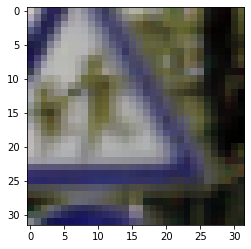

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


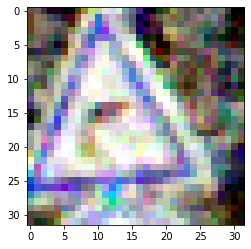

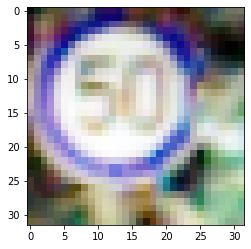

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


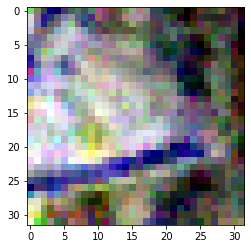

In [11]:
plt.imshow(testX[3])
plt.show()
plt.imshow(X_adv[3])
plt.show()

plt.imshow(testX[1])
plt.show()
plt.imshow(X_adv[1])
plt.show()

In [13]:
def get_model(dataset):
    return load_model('model_%s.h5' % dataset)

model = get_model('traffic_sign')
_, acc = model.evaluate(X_adv, test_y, batch_size=256,verbose=0)
print('accuracy is ',acc)

accuracy is  0.03029336780309677


In [9]:
def KL(prob_a, prob_b):
    term1 = prob_a*np.log(prob_a)
    term2 = prob_a*np.log(prob_b)
    term1 = np.sum(term1, axis=1)
    term2 = np.sum(term2, axis=1)
    return (term1-term2)
#     term = prob_a*np.log(prob_a/prob_b)
#     term = np.sum(term, axis=1)
#     return term

def jpeg_compress(x, quality=75):
    return tf.image.decode_jpeg(
        tf.image.encode_jpeg(
            x, format='rgb', quality=quality),
        channels=3)

def calc_TP_FP_rate(y_true, y_pred):
    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    
    #print('printing shape ',y_true.shape,y_pred.shape)

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if((y_true[i]==y_pred[i]) and (y_true[i]==1)):
            TP += 1
        if(y_pred[i]==1 and (y_true[i]!=y_pred[i])):
            FP += 1
        if((y_true[i]==y_pred[i]) and y_true[i]==0):
            TN += 1
        if((y_pred[i]==0) and (y_true[i]!=y_pred[i])):
            FN += 1
    
    print('tp, fp, fn, tn are ',TP,FP,TN,FN)
    # Calculate true positive rate and false positive rate
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    return tpr, fpr

def generate_adversial_dataset():
    #All adversial images are appended to all clean images
    test_sz       = testX.shape[0]
    y_test_adv    = np.ones(test_sz,)
    y_test_clean  = np.zeros(test_sz,)
    X_test_adv    = X_adv
    X_test_clean  = testX
    X_test_vg     = np.append(X_test_adv, X_test_clean, axis=0)
    y_test_vg     = np.append(y_test_adv, y_test_clean, axis=0)
    
    return (X_test_vg, y_test_vg)
    

def transform_image(X_adv):
    """
    :param X_adv: adversial input array 
    :return X_adv_transform: adversial transformed array
    """
    X_adv_transform = []
    
    for adv_image in X_adv:
        adv_image_transform = jpeg_compress(adv_image, quality=92)
        X_adv_transform.append(adv_image_transform)
    X_adv_transform = np.array(X_adv_transform)
    
    return X_adv_transform
    
    
#Implemeting the     
def vision_guard(X_test_adv, model, threshold):
    """
    :param X_test:
    :param test_adv:
    :param model:
    :param threshold
    :return y_pred:
    """
  
    
    prob_a           = model.predict(X_test_adv)
    X_test_transform = transform_image(X_test_adv)
    prob_b           = model.predict(X_test_transform)
    
 
    
    kl_div = np.minimum(KL(prob_a, prob_b),KL(prob_b, prob_a))
    y_pred = (kl_div>threshold)*1
    return y_pred
    
   
    
    
    
    
  
    

In [10]:
X_test_vg, y_test_vg = generate_adversial_dataset()

/home/anirudh/ml/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/anirudh/ml/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/anirudh/ml/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


hello1
hello2
hello3
hello4
hello1
hello2
hello3
hello4
kl_div is  [18.343624 19.25367  11.347217 ... 12.611639 21.280647 17.822392]
hello5
hello6


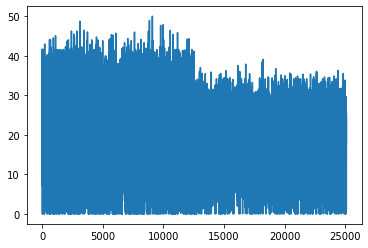

In [12]:
threshold = 20 #Example threshold for demonstration, not optimal
y_test_pred = vision_guard(X_test_vg, model, threshold)

In [11]:
probability_thresholds = np.linspace(0,50,num=100)
tp_rate_list = []
fp_rate_list = []

for threshold in probability_thresholds:
    print('threshold is ',threshold)
    y_test_pred = vision_guard(X_test_vg, model, threshold)
    tp_rate, fp_rate = calc_TP_FP_rate(y_test_vg, y_test_pred)
    tp_rate_list.append(tp_rate)
    fp_rate_list.append(fp_rate)

threshold is  0.0


/home/anirudh/ml/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/anirudh/ml/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/home/anirudh/ml/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


tp, fp, fn, tn are  12498 12544 0 46
threshold is  0.5050505050505051
tp, fp, fn, tn are  12293 12395 149 251
threshold is  1.0101010101010102
tp, fp, fn, tn are  12264 12378 166 280
threshold is  1.5151515151515151
tp, fp, fn, tn are  12249 12360 184 295
threshold is  2.0202020202020203
tp, fp, fn, tn are  12230 12342 202 314
threshold is  2.5252525252525255
tp, fp, fn, tn are  12210 12320 224 334
threshold is  3.0303030303030303
tp, fp, fn, tn are  12184 12296 248 360
threshold is  3.5353535353535355
tp, fp, fn, tn are  12150 12264 280 394
threshold is  4.040404040404041
tp, fp, fn, tn are  12129 12222 322 415
threshold is  4.545454545454546
tp, fp, fn, tn are  12105 12176 368 439
threshold is  5.050505050505051
tp, fp, fn, tn are  12073 12130 414 471
threshold is  5.555555555555556
tp, fp, fn, tn are  12018 12057 487 526
threshold is  6.0606060606060606
tp, fp, fn, tn are  11975 11964 580 569
threshold is  6.565656565656566
tp, fp, fn, tn are  11939 11878 666 605
threshold is  7.070

In [12]:
#optimal threshold is obtained when fp rate is around 0.8
min_diff = 10000000
optimal_threshold = 0
cnt = 0
for fp_rate in fp_rate_list:
    if(abs(fp_rate-0.8)<min_diff):
        min_diff = abs(fp_rate-0.8)
        optimal_threshold = probability_thresholds[cnt]
    cnt+=1
    
print('optimal threshold is ', optimal_threshold)

optimal threshold is  11.111111111111112


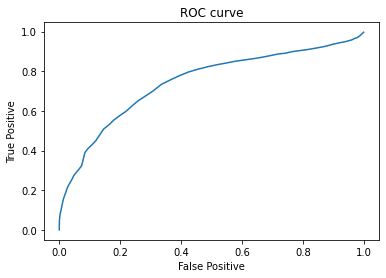

In [18]:
plt.plot(fp_rate_list, tp_rate_list) 
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC curve')
plt.show()

In [19]:
auc(fp_rate_list, tp_rate_list)

0.7437242303774387

In [32]:
import time
import random


def get_random_image_to_test():
    rnd_val = random.randint(0,1)
    print('rand_val is ',rnd_val)
    if(rnd_val==1): #send adversial image as input
        rnd_idx = random.randint(0, X_adv.shape[0])
        return X_adv[rnd_idx:(rnd_idx+1)] #here X_adv[rnd_idx] is not used because vision gaurd algo requires
    else:                                 #inp shape to be 1*32*32*3 and not 32*32*3
        rnd_idx = random.randint(0, testX.shape[0])
        return testX[rnd_idx:(rnd_idx+1)]
        
        


def simulate_simulink_model():
    while(True):
        f = open('/home/anirudh/Documents/input.txt','r')
        ip = f.readline()
        print('input is',ip)
        f.close()
        
        f = open('/home/anirudh/Documents/input.txt','w') #after reading update state as absent
        f.write('absent')
        f.close()
        if(ip.strip()=='present'):#input present
            img = get_random_image_to_test()
            y_pred = vision_guard(img, model, optimal_threshold)
            adv_file = open('isAdv.txt','w')
            print('pred is ',y_pred)
            adv_file.write('%d' % y_pred[0])
            adv_file.close()
        print('sleeping')    
        time.sleep(6)

In [33]:
simulate_simulink_model()

input is present

rand_val is  0
pred is  [1]
sleeping
input is absent
sleeping


KeyboardInterrupt: 

In [ ]:
plt.imshow(testX[0])
plt.show()

plt.imshow(X_adv[0].astype('uint8'))
plt.show()